# Shadow Detection Methods

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage import io, color
from skimage.feature import hog
from skimage import data, exposure

In [ ]:
def shadow_using_paper(image):
    lab = color.rgb2lab(image)
    L = lab.T[0].T
    A = lab.T[1].T
    B = lab.T[2].T
    
    if A.mean() + B.mean()<= 256:
        threshold = L.mean() - L.std()/3
        shadows = (L<=threshold).astype(np.int)
        return shadows
    else:
        L_index_sort = np.argsort(L)
        print(L_index_sort)
        print('Superior')
        return np.zeros(L.shape)
    
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def get_hog(image):
    fd, hog_image = hog(image, orientations=8, pixels_per_cell=(2, 2),
                        cells_per_block=(1, 1), visualize=True, multichannel=True)
    # Rescale histogram for better display
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    return hog_image_rescaled

def display_transformation(image, transformation, transformation_name, histogram=False):
    if histogram:
        fig, axes = plt.subplots(1, 3, figsize=(18, 1.05*18/3), sharex=True, sharey=True, subplot_kw={'aspect':"auto"})
    else:
        fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)
            
    axes[0].axis('off')
    axes[0].imshow(image, cmap=plt.cm.gray)
    axes[0].set_title('Input image')
    
    shadows = transformation(image)
    
    axes[1].axis('off')
    axes[1].imshow(shadows, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    axes[1].set_title(transformation_name)
    
    if histogram:
            
        color = ('b','g','r')
        for channel,col in enumerate(color):
            histr = cv2.calcHist([image],[channel],None,[256],[0,256])
            axes[2].plot(histr,color = col)
           
        axes[2].set_title('Image Histogram')

    
    plt.show()

def display_method(root_folder, transformation, transformation_name, nb_images=50, histogram=False):
    i = 0
    for subdir, dirs, files in os.walk(root_folder, topdown=True):
        for file in files:
            if i==50:
                return
            image_path = os.path.join(subdir, file)
            image = plt.imread(os.path.join(root_folder, image_path))
            display_transformation(image, transformation, transformation_name, histogram=histogram)
            i += 1

In [ ]:
root_folder = "C:\\Users\\AISG\\Documents\\Jonas\\Detected_Boxes_TMS"

# Methode 1 : A Shadow Detection and Removal from a Single Image Using LAB Color Space 

Implements the method of the paper cited below in the function `shadow_using_paper`

http://cit.iit.bas.bg/CIT_2013/v13-1/S_Murali,%20V_Govindan.pdf

http://ijcsi.org/papers/IJCSI-10-4-2-270-273.pdf

In [ ]:
display_method(root_folder, shadow_using_paper, 'Shadows (white areas)', nb_images=100)

# Methode 2 : Crater detection from commercial satellite imagery to estimate unexploded ordnance in Cambodian agricultural land

## Stage 1. Patch-based SVM classification using HOG (Histogram of Oriented Gradient) and spectrum information

### A. Create Training Vectors 
    1. Extract contour shapes features using Histogram Of Gradient (HOG).
    2. Histogram Distribution of the spectral values of each patch (bounding boxes in our cases)
    3. Concatenate HOG and HDSp
    4. PCA on that vector to preserve 0.9 of the cumulative sum of the eigenvalues. ==> first stage vector

### B. Train SVM using the HOG + Spectrum histogram features
    - Square of 8x8 pixels (in our case, we have bounding boxes averaging 64x64 in the satellite images (256x256), more for the original dataset since the images are 640x640.  ==> Need to find a shape that fits first dataset for training and second dataset for testing (resize, down or up, images or bounding boxes?)
    - Optimal parameters of SVM are identified by 10-fold cross validation using Sckikit-Learn Library

## Stage 2. Novel feature extraction and learning on random forest

A second stage of processing uses shape features more specifically designed for classifying bomb craters, such as area *size* and *isotropy* (having a physical property which has the same value when measured in different directions).

### A. Segmentation
    1. Candidate patches (bounding boxes) are segmented using a Mean-Shift segmentation algorithm
    2. If a patch can be segmented to a few regions where the center regions are relatively isotropic and flat, there is chance that the patch may contain a bomb crater
    3. an adaptive mean-shift (MS) segmentation method is used to tune the associated parameters (i.e., the range bandwidth) of the classic MS algorithm : our adaptive MS method tunes the range radius dynamically and ensures that only one segment appears in the center of the patch

### B. Adaptive mean-shift based shape feature
    1. The extracted features from this segment are used for classification.
    2. Extracts the shape, location and radiometric information out of the segment and stacks the information as a feature vector : obtain minimum and maximum distance from bounding boxes center to the segment boundaries, d_min and d_max, and maximum compactness r_max (maximum distance from the barycenter of the segment to its boundaries) and others (Table 1) to get a feature vector :
$$
v_0 = (\alpha, d_{max}, d_{min}, r_{max}, n_{groups}, R, G, B) \in R^8
$$

### C. Central SIFT Point
    1. 128-dimension SIFT feature vector extract key point features
    2. Only the feature vector associated with a detected point in the central segment is used. If multiple SIFT point is detected in the segment, only the SIFT point closest to the patch (bounding boxe) center is used. 
    
$$
v_{final} = (v_0, v_{SIFT}) \in R^{136}
$$

### D. Binary Classification using Random Forest
    1. Random Forest model with 850 decision trees.
    2. Trained for 2 categories : likely bomb craters and false positive
    3. using v_{final}

https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0229826

In [ ]:
display_method(root_folder, get_hog, 'Histogram of Oriented Gradients', nb_images=100, histogram=False)

In [ ]:
image_path = 'C:\\Users\\AISG\\Documents\\Jonas\\Detected_Boxes_TMS\\model_7_0.0\\sat\\19\\437762\\Satellite_19_437762_283552_0.jpg'

image = cv2.imread(image_path)

plt.imshow(image)
plt.show()
print(image.shape)

# Methode 3 : Shadow detection in colour high‐resolution satellite images

https://www.tandfonline.com/doi/full/10.1080/01431160701395302

## Stage 1 : Preprocessing
    1. RGB --> c_3 --> convolved with a 3x3 average kernel to minimize the effect of noise --> smoothed c_3
$$
c_3 = arctan(\frac{B}{max(R,G)})
$$
    2. RGB --> HSV --> S and V
    3. The intensity V --> convoled with a 3x3 Sobel filter --> edges
    4. ==> We get smoothed c_3, S, V and edges.

In [ ]:
def compute_c3(image):
    c3 = np.arctan(image[:,:,0]/np.maximum(image[:,:,1], image[:,:,2]))
    return c3

def apply_average_kernel(img, kernel_size):
    return cv2.blur(img,(kernel_size, kernel_size))

def get_hsv(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

def compute_sobelx(v, kernel_size):
    return cv2.Sobel(v,cv2.CV_64F,1,0,ksize=kernel_size)

def preprocessing(image):
    c3 = compute_c3(image)
    c3_smoothed = apply_average_kernel(c3, 3)
    hsv = get_hsv(image)
    edges = compute_sobelx(hsv[:,:,2], kernel_size=3)
    return c3, hsv[:,:,1], hsv[:,:,2], edges

In [ ]:
c3, S, V, edges = preprocessing(image)

## Stage 2 : Shadow Detection Stage

Apply a region growing process over the smoothed c_3 component : start with a small group of pixels, called seed-window, and recursively adds neighbour pixels as long as they confirm some rules -> at least one per shadow region and no seed at non-shadow pixels.

### A. Seed selection
    1. A seed is a square region of 5x5 pixels (minimum size allowed for the shadows):
        a. The centre is a local maximum
        b. its 5x5 neighbourhood must have values higher than the mean of the whole c_3 image
        c. mean(V[window]) < threshold T_v (shadow darkness), set to 0.35
        d. mean(S[window]) > threshold T_s, set to 0.02
        e. None of the window's pixels must belong to another previous seed-window
    2. Each of the seed-windows is taken as a shadow prototype which is charaterized by a Gaussian Distribution:
$
N(\hat{c_3}, \sigma)
$

In [ ]:
def zero_pad(matrix, pad_left, pad_right, pad_top, pad_bottom):
    h, w = matrix.shape
    H, W = h+pad_top+pad_bottom, w+pad_left+pad_right
    matrix_pad = np.zeros((H, W))
    matrix_pad[pad_bottom:H-pad_top,pad_left:W-pad_right] = matrix
    return matrix_pad

def check_local_maximum(candidate_seed, candidate_window):
    if candidate_seed >= np.max(candidate_window):
        return True
    else:
        return False
    
def check_value_neighbourhood(candidate_window, mean_c3, ratio=1/2):
    if np.min(candidate_window) > mean_c3*ratio:  # should be > mean_c3 according to the article but change to fit better
        return True
    else:
        return False

def check_mean_V(V_window, threshold_v):
    if np.mean(V_window/255.0) < threshold_v:
        return True
    else:
        return False

def check_mean_S(S_window, threshold_s):
    if np.mean(S_window/255.0) > threshold_s:
        return True
    else:
        return False

def check_window_already_seed(i, j, seeds, delay, minimum_size_window):
    d = delay
    m = minimum_size_window
    if np.max(seeds[i-d:i+m, j-d:j+m]) > 0:
        return False
    else:
        return True
    
def seed_selection(c3, S, V, edges, minimum_size_window=5, threshold_v=0.45, threshold_s=0.02, ratio=1/2):
    h, w = c3.shape
    seeds = np.zeros((h, w))
    prototype = {}
    k = 1
    d = minimum_size_window-1
    m = minimum_size_window
    c3_pad = zero_pad(c3, d, d, d, d)
    S_pad = zero_pad(S, d, d, d, d)
    V_pad = zero_pad(V, d, d, d, d)
    mean_c3 = np.mean(c3)
    
    for i in range(h):
        for j in range(w):
            candidate_seed = c3[i][j]
            candidate_window_c3 = c3_pad[i+d-d:i+d+m, j+d-d:j+d+m]
            candidate_window_S = S_pad[i+d-d:i+d+m, j+d-d:j+d+m]
            candidate_window_V = V_pad[i+d-d:i+d+m, j+d-d:j+d+m]
            # condition a:
            if not check_local_maximum(candidate_seed, candidate_window_c3):
                continue
            # condition b:
            elif not check_value_neighbourhood(candidate_window_c3, mean_c3, ratio=ratio):
                continue
            # condition c:
            elif not check_mean_V(candidate_window_V, threshold_v=threshold_v): # hyper-parameter
                continue
            # condition d:
            elif not check_mean_S(candidate_window_S, threshold_s=threshold_s): # hyper-parameter
                continue
            # continue e
            elif not check_window_already_seed(i, j, seeds, d, m):
                continue
            else:
                # accept candidate and candidate window
                seeds[i-d:i+m, j-d:j+m] = k*np.ones((minimum_size_window*2-1, minimum_size_window*2-1))
                indices = []
                for u in range(i-d, i+m):
                    for v in range(j-d, j+m):
                        indices.append((u,v))
                prototype[k] = {'indices':indices,
                                'values':candidate_window_c3.ravel(),
                                'mean': np.mean(candidate_window_c3),
                                'sigma': np.std(candidate_window_c3)}
                k += 1
    return seeds.astype(int), prototype

def display_seed_on_image(image, seeds):
    image_seed = image.copy()
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if seeds[i][j] > 1:
                image_seed[i,j,:] = [0,0,255]
    return image_seed

def display_side_by_side_image(image, image_seed):
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)
            
    axes[0].axis('off')
    axes[0].imshow(image)
    axes[0].set_title('Input image')
    
    axes[1].axis('off')
    axes[1].imshow(image_seed)
    axes[1].set_title('Shadow seeds')
    
    plt.show()
    
def display_seed_initialization(root_folder, minimum_size_window=3, nb_images=100):
    n = 0
    for subdir, dirs, files in os.walk(root_folder, topdown=True):
        for file in files:
            image_path = os.path.join(subdir, file)
            image = cv2.imread(image_path)
            c3, S, V, edges = preprocessing(image)
            seeds, prototype = seed_selection(c3, S, V, edges, minimum_size_window=3)
            
            image_seed = display_seed_on_image(image, seeds)        
            display_side_by_side_image(image, image_seed)
    
            n += 1
            if n == nb_images:
                return

In [ ]:
image_path = 'C:\\Users\\AISG\\Documents\\Jonas\\Detected_Boxes_TMS\\model_7_0.0\\sat\\19\\437762\\Satellite_19_437762_283552_0.jpg'
image = cv2.imread(image_path)
c3, S, V, edges = preprocessing(image)
seeds, prototype = seed_selection(c3, S, V, edges, minimum_size_window=3)
display_seed_on_image(image, seeds)

In [ ]:
image_path_2 = 'C:\\Users\\AISG\\Documents\\Jonas\\Detected_Boxes_TMS\\model_7_0.0\\sat\\19\\438512/Satellite_19_438512_283636_0.jpg'

image = cv2.imread(image_path_2)
c3, S, V, edges = preprocessing(image)
seeds, prototype = seed_selection(c3, S, V, edges, minimum_size_window=3)
display_seed_on_image(image, seeds)

### B. Region Growing
    1. Region growing, executed recursively for all the eight neighbours of the boundary pixels of a growing region, starting with the seed window. A pixel is classified as shadow if it satisfies the following conditions:
        a. Not previously added to any shadow region already grown
        b. It is below a certain Mahalanobis distance d_0=3 from the mean(C_3[region]):

$$
\frac{|c_3-\hat{c_3}|}{\sigma} < d_0
$$

        c. The magnitude of the gradient of V < T_e = 0.30 (not a shadow boundary pixel)
        d. mean(V[window]) < threshold T_v (shadow darkness), set to 0.35
        e. mean(S[window]) > threshold T_s, set to 0.02
    2. If the pixel is incorporated, the gaussian distribution is updated with its c_3 value.
    3. Ends when no pixels added

In [ ]:
# scan neighbours of the boundary pixels
    
def check_pixel_in_shadow(prototype, i, j):
    for key, values in prototype.items():
        if (i,j) in values['indices']:
            return True
    return False

def check_pixel_neighbours_boundary_shadow(prototype, i, j):
    neighbours = [(i-1,j), (i+1,j), (i-1,j-1), (i, j-1), (i,j+1), (i+1, j+1), (i+1, j-1), (i-1, j+1)]
    for key, values in prototype.items():
        indices = values['indices']
        for neighbour in neighbours:
            if neighbour in indices:
                return key
    return 0

def check_mahalanobis_distance(pixel_c3, region_id, prototype, d_0 = 3):
    mean_c3 = prototype[region_id]['mean']
    sigma_c3 = prototype[region_id]['sigma']
    if np.abs(pixel_c3 - mean_c3)/sigma_c3 < d_0:
        return True
    else:
        return False

def region_growing(image, c3, S, V, edges, seeds, prototype, minimum_size_window=3, threshold_v=0.45, threshold_s=0.02, d_0=3):
    n, p, c = image.shape
    
    d = minimum_size_window-1
    m = minimum_size_window
    c3_pad = zero_pad(c3, d, d, d, d)
    S_pad = zero_pad(S, d, d, d, d)
    V_pad = zero_pad(V, d, d, d, d)
    
    pixel_added = True
    while pixel_added:
        pixel_added = False
        for i in range(n):
            for j in range(p):
                # check if pixel already in shadow area
                if check_pixel_in_shadow(prototype, i, j):
                    continue
                # check if pixel is a neighbours of a boundary pixel
                region_id = check_pixel_neighbours_boundary_shadow(prototype, i, j) 
                if region_id == 0:
                    continue
                pixel_c3 = c3[i][j]
                if not check_mahalanobis_distance(pixel_c3, region_id, prototype, d_0=d_0): # d_0 hyper-parameter
                    continue
                    
                # The magnitude of the gradient of V < T_e = 0.30 (not a shadow boundary pixel)
                # ???
                
                candidate_window_V = V_pad[i+d-d:i+d+m, j+d-d:j+d+m]    
                if not check_mean_V(candidate_window_V, threshold_v=threshold_v): # hyper-parameter
                    continue
                candidate_window_S = S_pad[i+d-d:i+d+m, j+d-d:j+d+m]
                # condition d:
                if not check_mean_S(candidate_window_S, threshold_s=threshold_s): # hyper-parameter
                    continue
                    
                # Add the pixel to the region region_id
                prototype[region_id]['indices'].append((i,j))
                prototype[region_id]['values']  = np.append(prototype[region_id]['values'], pixel_c3)
                prototype[region_id]['mean'] = np.mean(prototype[region_id]['values'])
                prototype[region_id]['sigma'] = np.std(prototype[region_id]['values'])

                # TODO: Add region merging 

    return prototype

def display_shadow_on_image(image, prototype):
    image_shadow = image.copy()
    for key,values in prototype.items():
        indices = values['indices']
        for indice in indices:
            i = indice[0]
            j = indice[1]
            image_shadow[i,j,:] = [0,0,255]    
    return image_shadow
    
def display_side_by_side_image_seed_shadow(image, image_seed, image_shadow):
    
    fig, axes = plt.subplots(1, 3, figsize=(14, 6), sharex=True, sharey=True)
            
    axes[0].axis('off')
    axes[0].imshow(image)
    axes[0].set_title('Input image')
    
    axes[1].axis('off')
    axes[1].imshow(image_seed)
    axes[1].set_title('Shadow seeds')
    
    axes[2].axis('off')
    axes[2].imshow(image_shadow)
    axes[2].set_title('Shadows')
    
    plt.show()
    
def display_shadow(root_folder, minimum_size_window=3, threshold_v=0.45, threshold_s=0.02, ratio=1/2, d_0=3, nb_images=100):
    n = 0
    for subdir, dirs, files in os.walk(root_folder, topdown=True):
        for file in files:
            image_path = os.path.join(subdir, file)
            image = cv2.imread(image_path)
            c3, S, V, edges = preprocessing(image)
            seeds, prototype = seed_selection(c3, S, V, edges, 
                                              minimum_size_window=minimum_size_window, 
                                              threshold_v=threshold_v, 
                                              threshold_s=threshold_s, 
                                              ratio=ratio)
            prototype = region_growing(image, c3, S, V, edges, seeds, prototype, 
                                       minimum_size_window=minimum_size_window,
                                       threshold_v=threshold_v,
                                       threshold_s=threshold_s,
                                       d_0=d_0)
            image_seed = display_seed_on_image(image, seeds)
            image_shadow = display_shadow_on_image(image, prototype)
            display_side_by_side_image_seed_shadow(image, image_seed, image_shadow)
            n += 1
            if n == nb_images:
                return

# Test of Method 3 on Detected Helipads in Manilla

In [ ]:
detected_helipad_folder = "C:\\Users\\AISG\\Documents\\Jonas\\Helipad\\Real_World_Detected_Boxes\\model_10_0.0_groundtruth\\helipad"

display_shadow(detected_helipad_folder, 
               minimum_size_window=3, 
               threshold_v=0.3,
               threshold_s=0.02,
               ratio=1,
               d_0=3,
               nb_images=100)

# Test of Method 3 on Detected False Positive in Manilla

In [ ]:
detected_false_positive_folder = "C:\\Users\\AISG\\Documents\\Jonas\\Helipad\\Real_World_Detected_Boxes\\model_10_0.0_groundtruth\\false_positive"

display_shadow(detected_false_positive_folder, 
               minimum_size_window=3, 
               threshold_v=0.3,
               threshold_s=0.02,
               ratio=1, 
               nb_images=50)

C:\Users\AISG\Documents\Jonas\helipad_detection\src\bb_analysis\shadow_detection.py:37: RuntimeWarning: invalid value encountered in true_divide
  c3 = np.arctan(image[:,:,0]/np.maximum(image[:,:,1], image[:,:,2]))


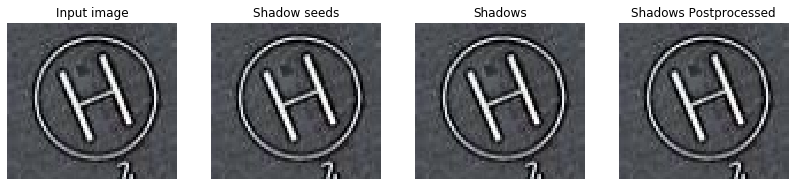

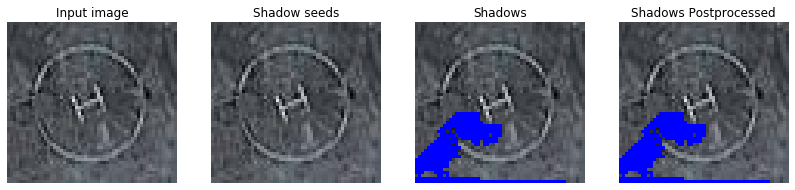

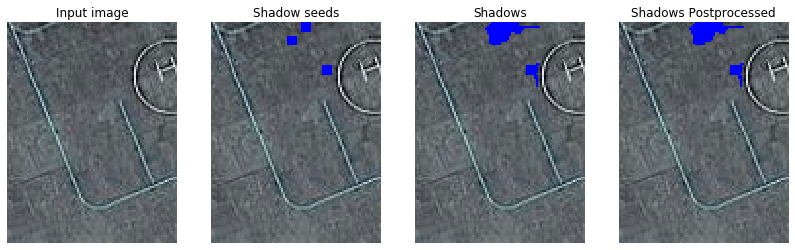

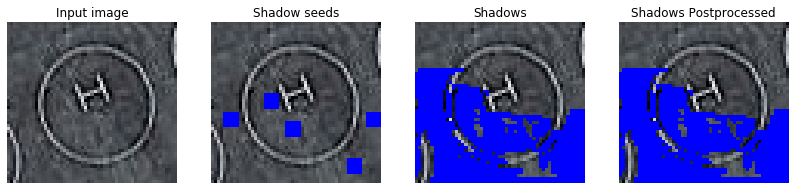

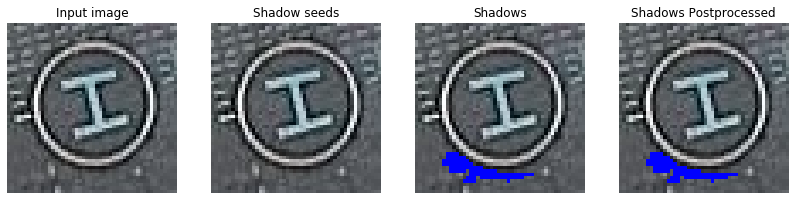

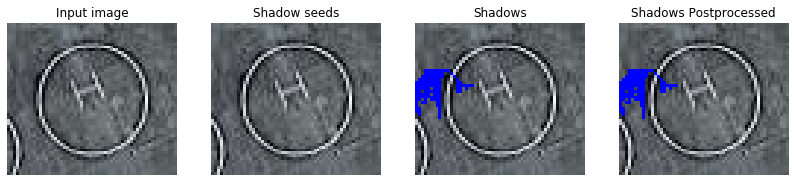

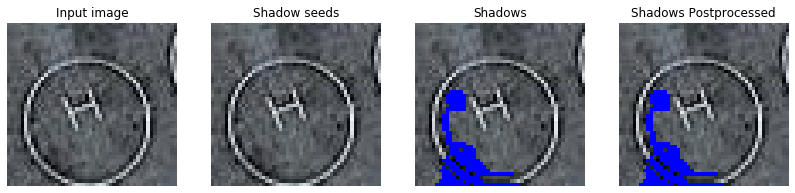

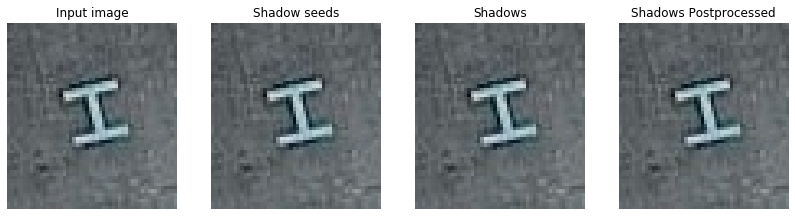

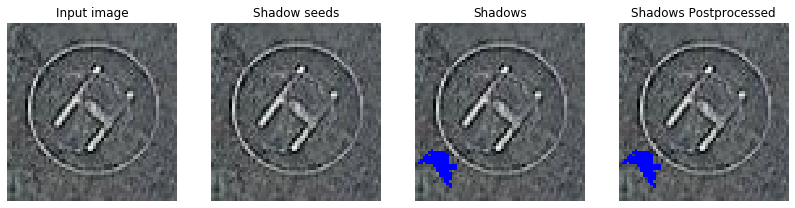

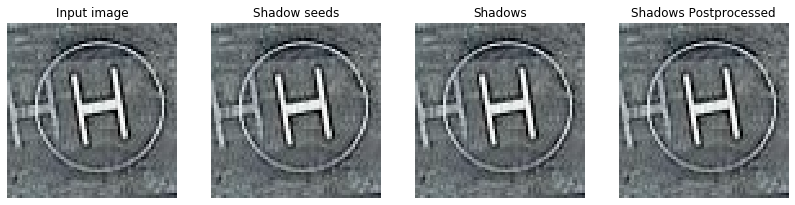

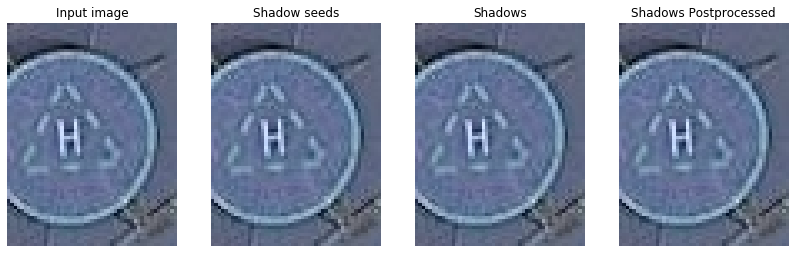

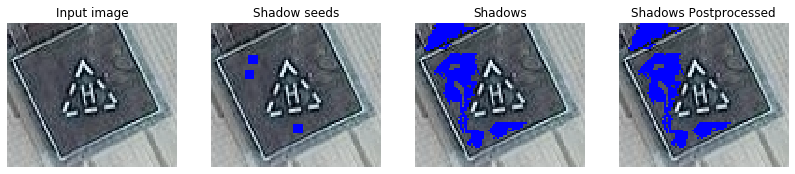

C:\Users\AISG\Documents\Jonas\helipad_detection\src\bb_analysis\shadow_detection.py:37: RuntimeWarning: divide by zero encountered in true_divide
  c3 = np.arctan(image[:,:,0]/np.maximum(image[:,:,1], image[:,:,2]))


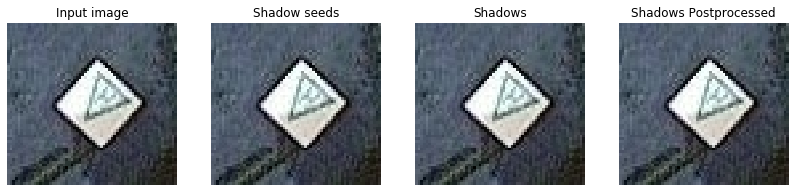

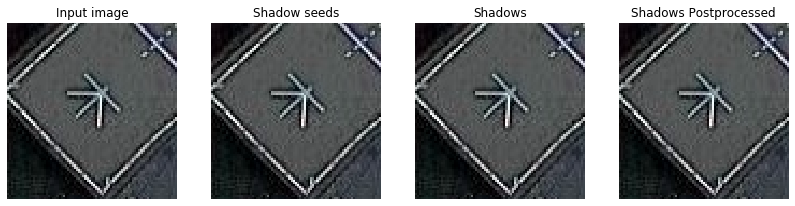

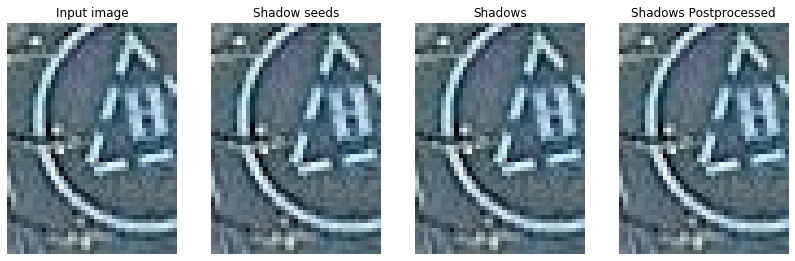

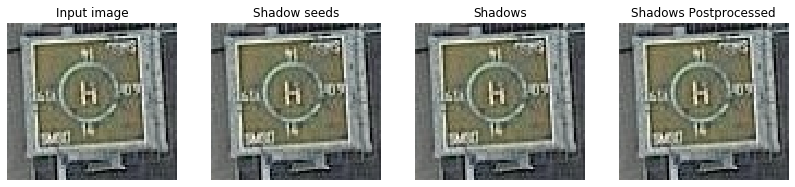

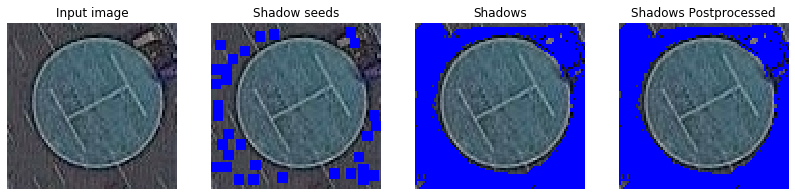

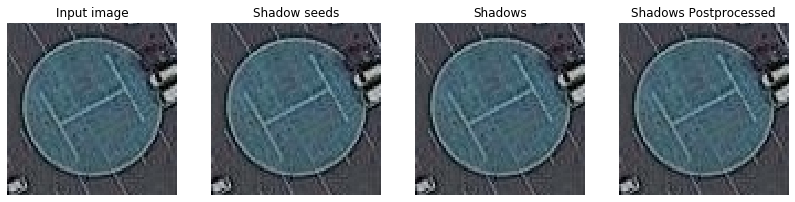

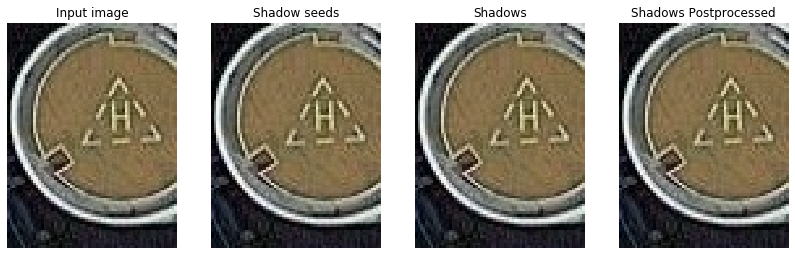

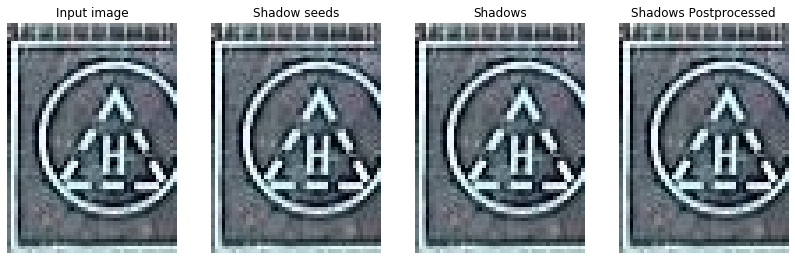

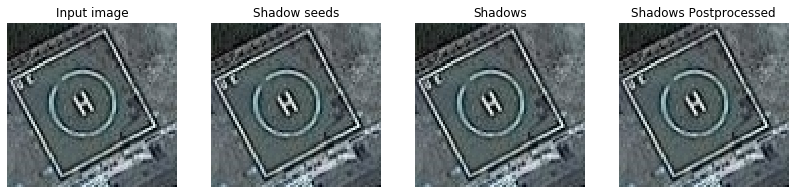

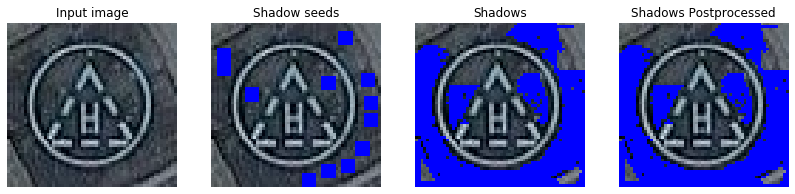

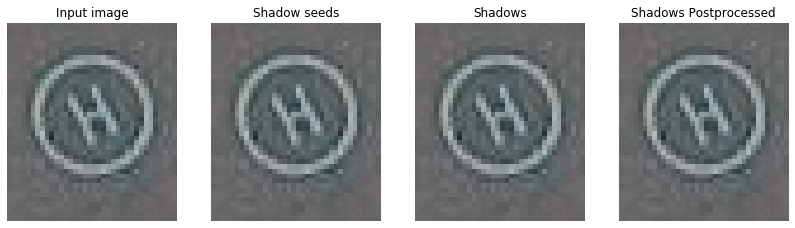

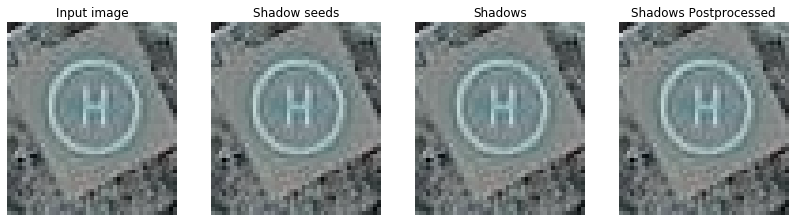

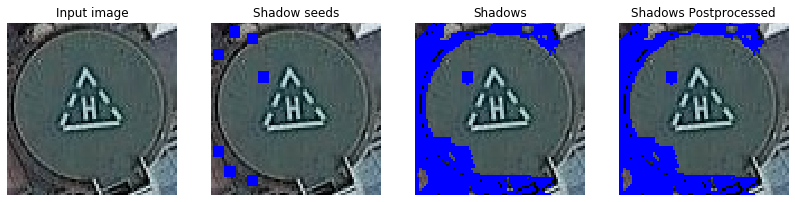

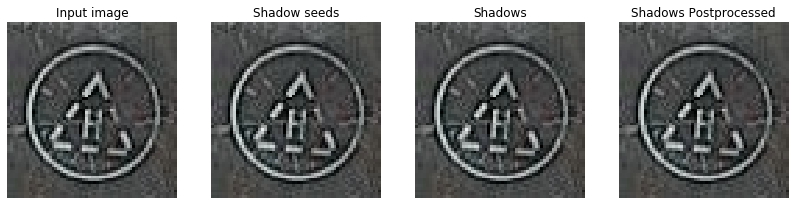

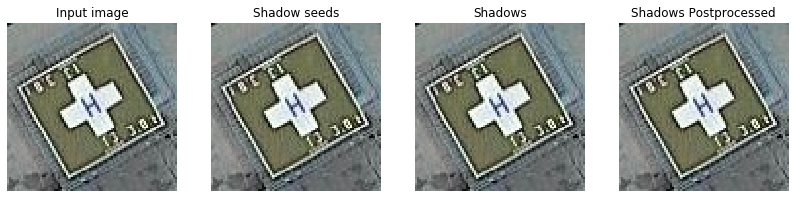

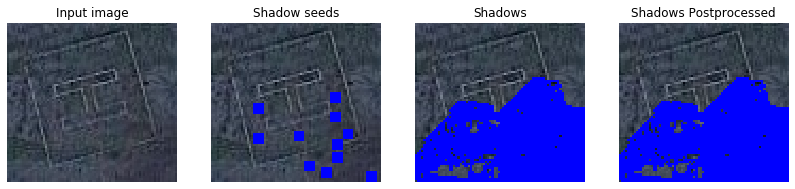

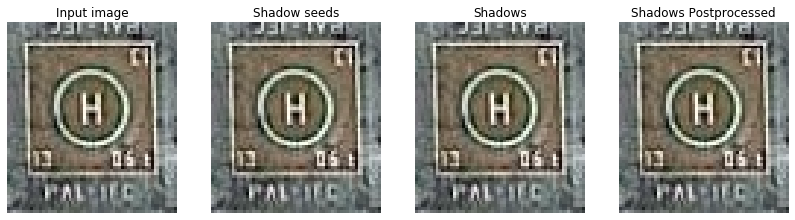

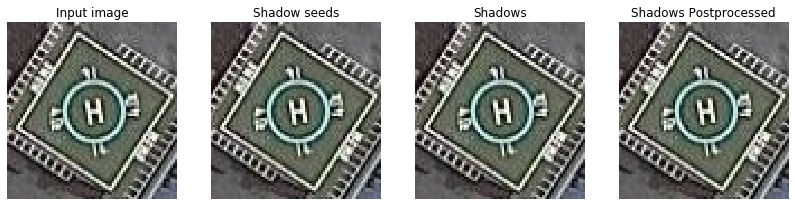

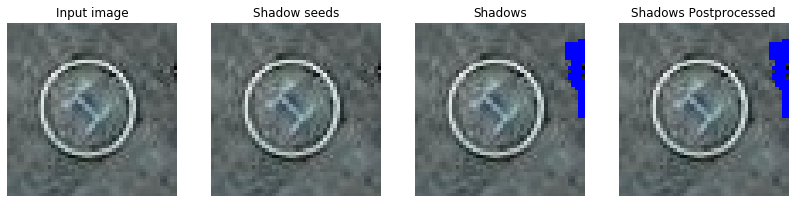

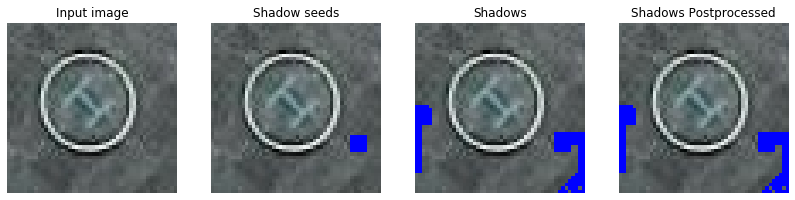

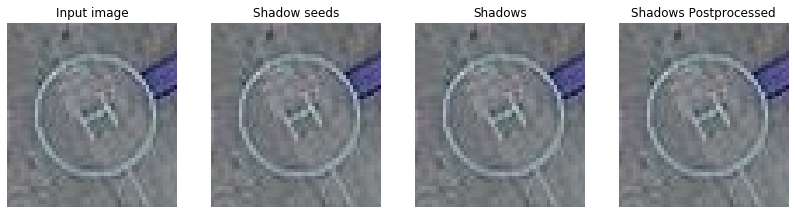

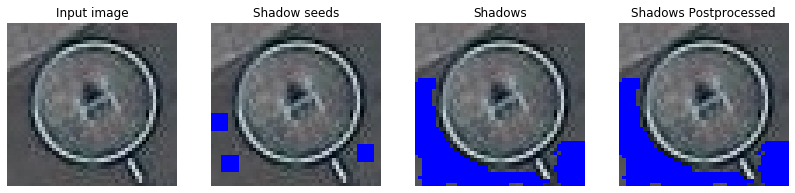

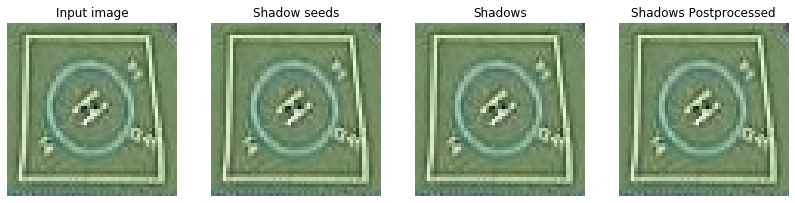

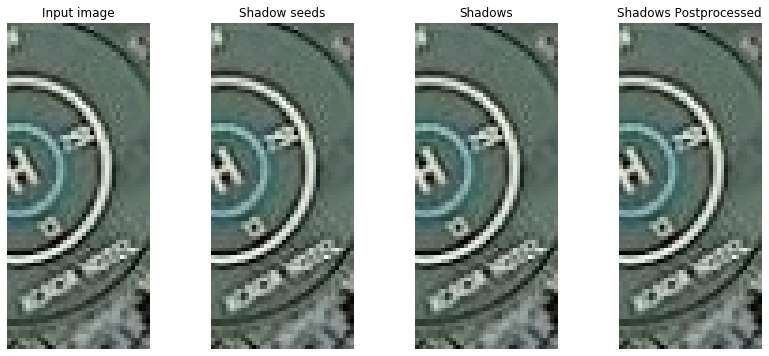

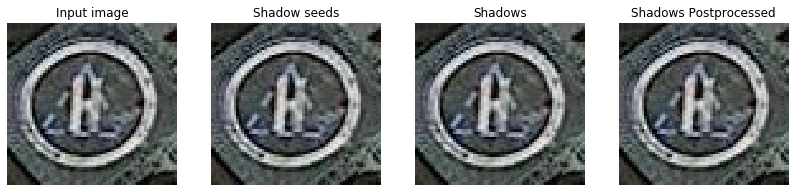

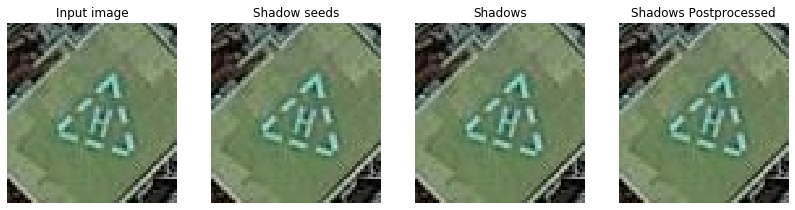

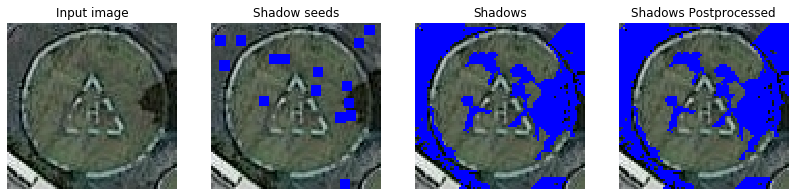

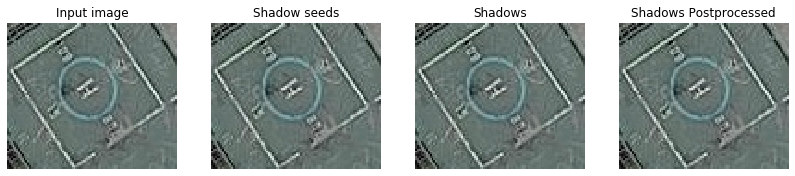

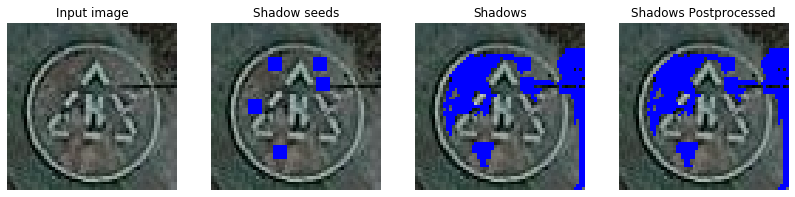

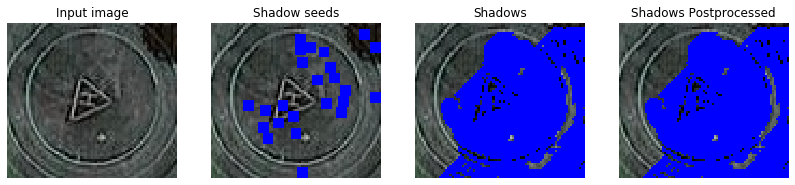

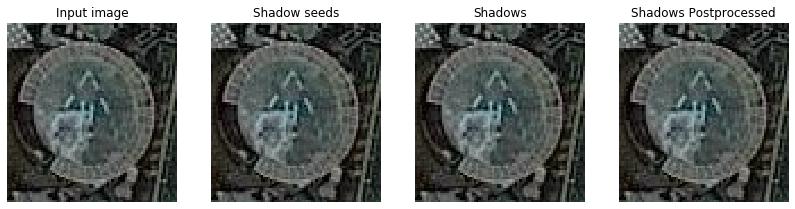

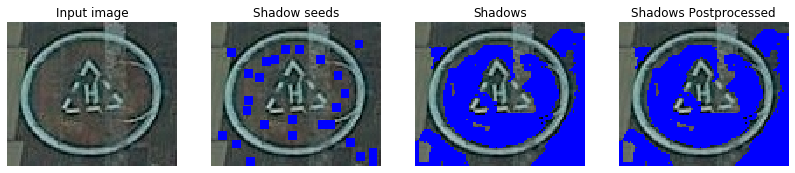

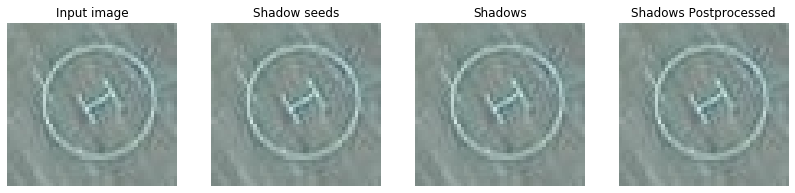

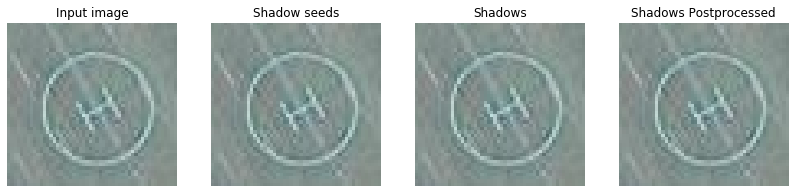

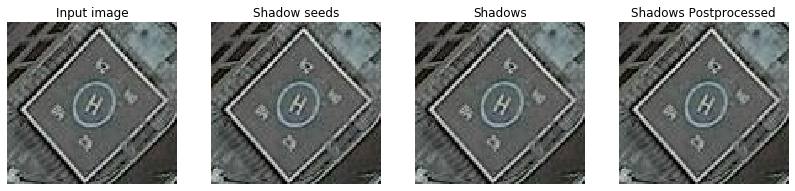

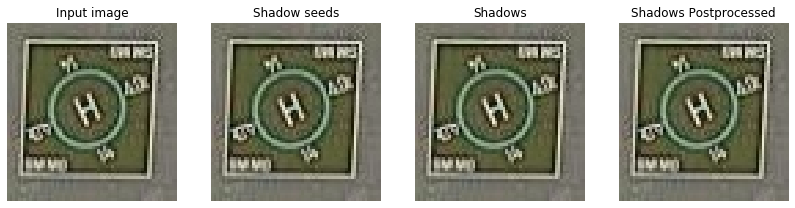

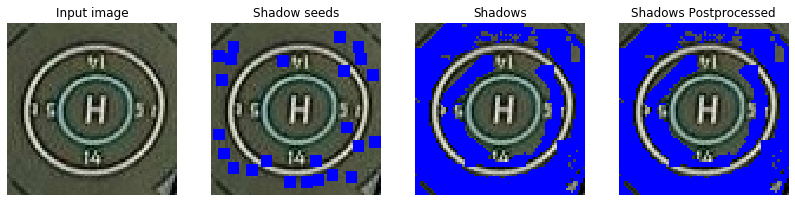

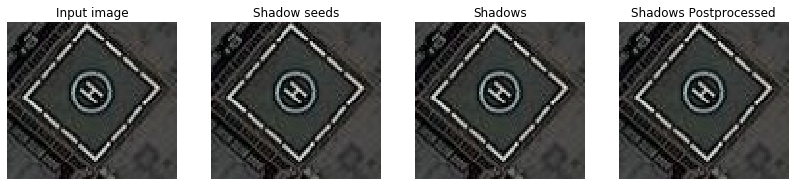

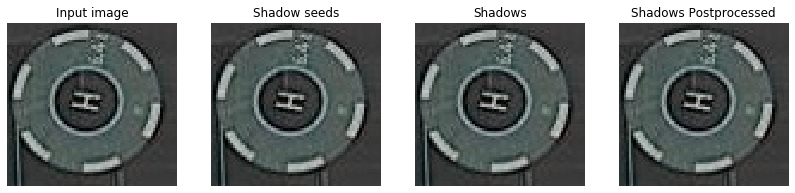

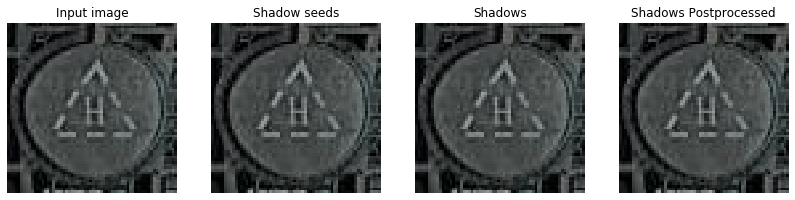

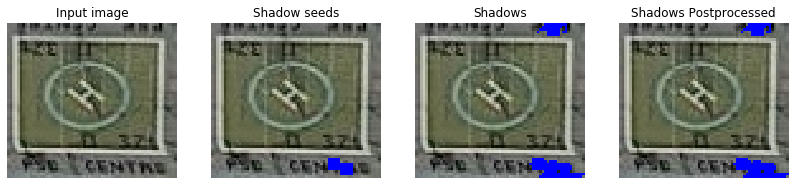

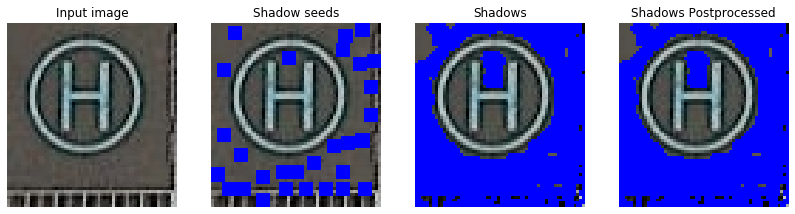

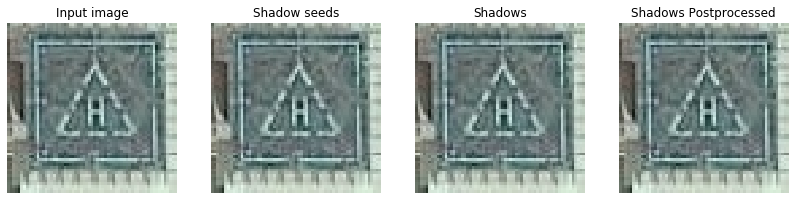

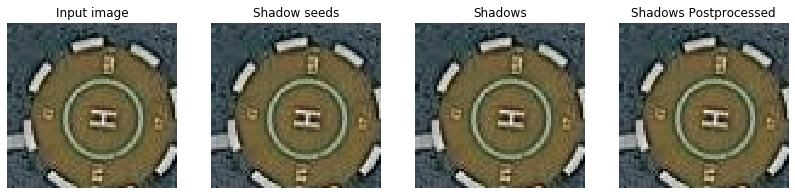

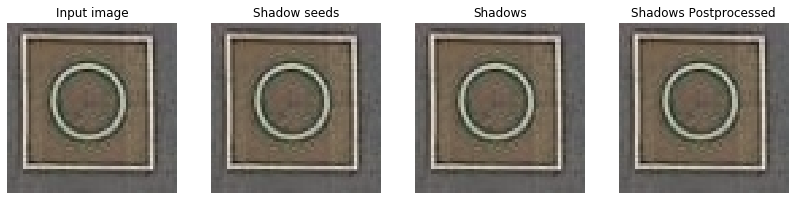

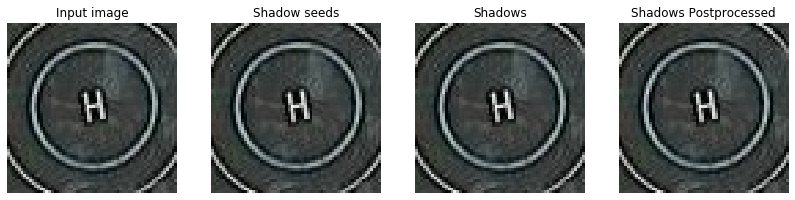

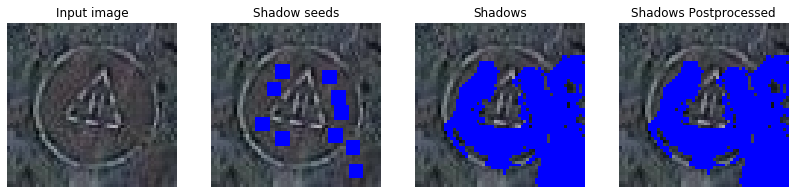

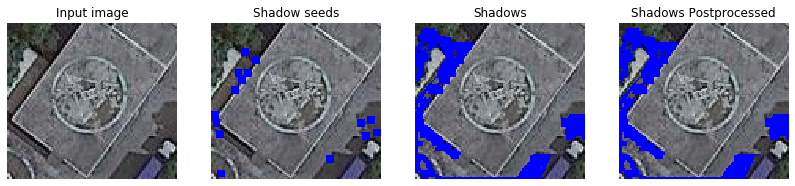

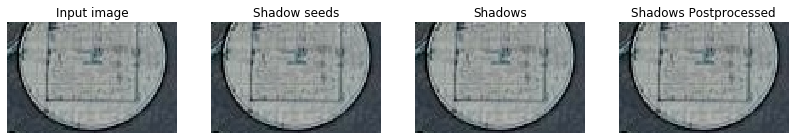

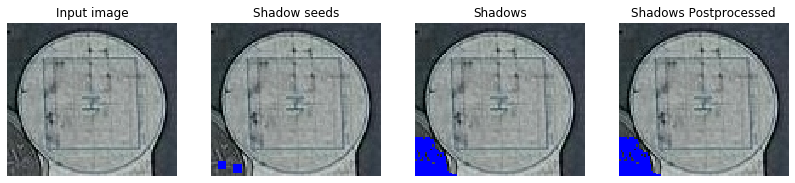

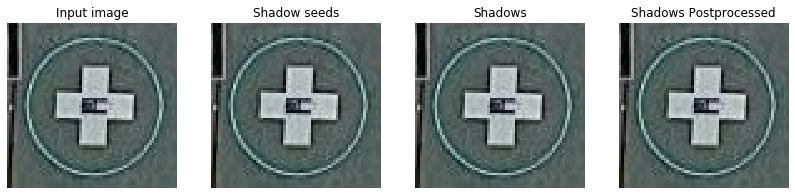

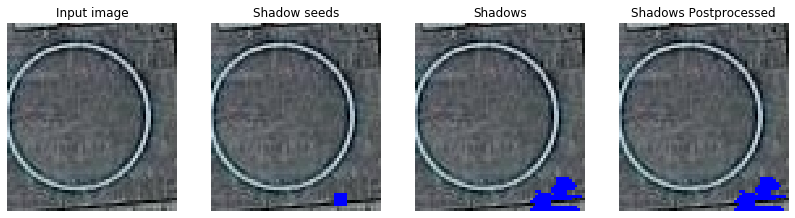

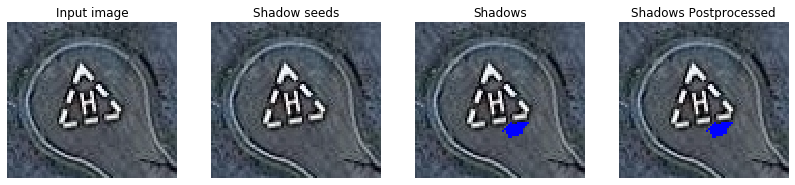

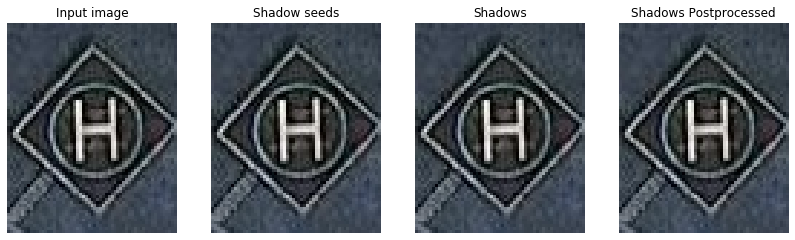

In [1]:
import os
import cv2
from shadow_detection import ShadowDetection

detected_helipad_folder = "C:\\Users\\AISG\\Documents\\Jonas\\Helipad\\Real_World_Detected_Boxes\\model_10_0.0_groundtruth\\helipad"

for subdir, dirs, files in os.walk(detected_helipad_folder, topdown=True):
    for file in files:
        
        image_path = os.path.join(subdir, file)
        image = cv2.imread(image_path)
        
        shadow_detection = ShadowDetection(image,
                                           minimum_size_window=3,
                                           threshold_v=0.35,
                                           threshold_s=0.02,
                                           ratio=1,
                                           d_0=3)
        
        shadow_detection.run(verbose=3)
        
